In [ ]:
!pip install -U datasets transformers accelerate bitsandbytes trl peft
from datasets import load_dataset
import pandas as pd
from transformers import AutoTokenizer,AutoModelForCausalLM,BitsAndBytesConfig,TrainingArguments
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
from trl import SFTTrainer
from transformers import pipeline

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# **FINE TUNING Llama2 with coding examples for coding assistantce**


This can achevied in following steps:

1.DOWNLOAD hugging face format llama2 model from Hugging face and tokenizer into colab

2.Preprocess the data to training format

3.Load model into RAM by quantizing using bitsandbytes and configure the LORA parameters

4.Finetune the model using LORA technique from peft with sfttrainer



# **PREPROCESING THE DATA**

In [12]:
df=pd.read_csv("/content/python_code_dataset.csv")

model_name="meta-llama/Llama-2-7b-hf"

new_model="prac/Llama-2-7b-hf-finetuned-code"


In [4]:
dataset=load_dataset("csv",data_files="/content/python_code_dataset.csv",split="train[0:10000]")

tokenizer=AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

def format_prompt(sample):
    system_prompt="you are an perfect coder who codes based on the instruction provided that describes a task and Write a response that appropriately completes the request "
    instruction=sample['instruction']
    input=sample["input"]
    answer=sample["output"]
    prompt=f"<s>[INST]<<SYS>> {system_prompt}<</SYS>>Instruction:{instruction}\n Input:{input}[/INST]\n {answer}</s>"
    sample['prompt']=prompt
    return sample

dataset=dataset.map(format_prompt)
dataset=dataset.remove_columns(['instruction', 'input', 'output'])
dataset=dataset.shuffle()

dataset_split = dataset.train_test_split(test_size=0.1)
train_data = dataset_split["train"]
test_data = dataset_split["test"]


Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
def tokens_len(sample):
    sample["prompt"]=len(tokenizer(sample['prompt'])["input_ids"])
    return sample

dataset_tok=dataset.map(tokens_len)
df_dataset=dataset_tok.to_pandas()



Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

           prompt
count  10000.0000
mean     246.2996
std      359.3209
min       71.0000
25%      137.7500
50%      179.0000
75%      244.0000
max     5714.0000


<Axes: xlabel='prompt', ylabel='Count'>

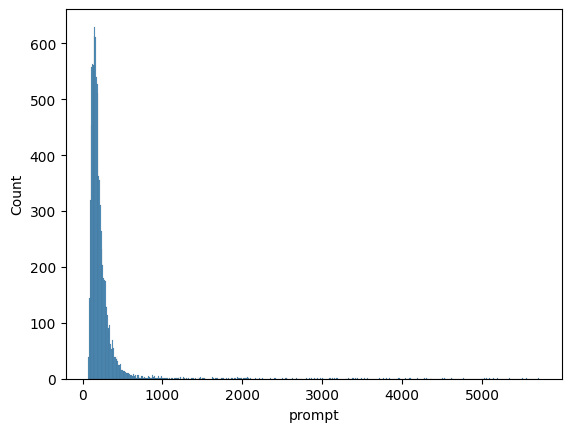

In [6]:
import seaborn as sb
print(df_dataset.describe())
sb.histplot(df_dataset,x="prompt")

# **Load model by quantizing**

In [7]:
bnb_config=BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=False
    )

model=AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf",quantization_config=bnb_config,device_map="auto")

model.config.use_cache = False
model.config.pretraining_tp = 1



config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [8]:
print(df['prompt'][1253])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Design a class in Python to represent a Rectangle, which has the two attributes 'length' and 'width'.

### Input:


### Output:
class Rectangle:
  def __init__(self, length, width):
    self.length = length
    self.width = width


 **Since it is a base model which is not trained upon code datasets it will** **hallucinate which can be seen below with the above example**

In [9]:

prompt="Design a class in Python to represent a Rectangle, which has the two attributes 'length' and 'width."

pipe=pipeline(task="text-generation",model=model,tokenizer=tokenizer,max_length=150)
print(pipe(prompt)[0]['generated_text'])

Design a class in Python to represent a Rectangle, which has the two attributes 'length' and 'width. nobody has asked a question yet. I have a class called Rectangle that has two attributes: length and width. This is a Python class that is defined to represent a rectangle. In this tutorial, we will learn about the Rectangle class in Python. I am going to create a class called Rectangle. In Python, the class keyword is used to define a class. In this case, we are going to define a class called Rectangle. In this article, you will learn how to create a class in Python. The class is a blueprint for an object. It's a class, but it's a class


# **Configuring the LORA model**

In [10]:
lora_config=LoraConfig(
    r=4,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj", "up_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)


# **Preparing the model for training**

In [11]:
training_arguments = TrainingArguments(
    output_dir="/results",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=16,
    gradient_checkpointing = True,
    optim="paged_adamw_32bit",
    save_steps=15,
    logging_steps=3,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="cosine"

)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side="right"

trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    peft_config=lora_config,
    dataset_text_field="prompt",
    max_seq_length=512,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=True,

)

trainer.train()
trainer.model.save_pretrained(new_model)

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
3,1.754400
6,1.537100
9,1.251500
12,1.117500
15,0.990200
18,0.908300
21,0.909000
24,0.906300
27,0.890600
30,0.880500


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
3,1.754400
6,1.537100
9,1.251500
12,1.117500
15,0.990200
18,0.908300
21,0.909000
24,0.906300
27,0.890600
30,0.880500


# **Merge the model**

In [ ]:
import torch
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="auto"
)
merged_model = PeftModel.from_pretrained(base_model, new_model)
merged_model = merged_model.merge_and_unload()


merged_model.save_pretrained("merged_model",safe_serialization=True)
tokenizer.save_pretrained("merged_model")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# **pushing the model to Hub**

In [24]:
merged_model.push_to_hub("Llama-2-7b-hf-finetuned-code",check_pr=True)
tokenizer.push_to_hub("Llama-2-7b-hf-finetuned-code",check_pr=True)

# **Checking the Finetuned Model**

In [2]:
merged=AutoModelForCausalLM.from_pretrained('merged_model')
tokenizer=AutoTokenizer.from_pretrained("merged_model")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [21]:
def prompt_for(instruction):
    system_prompt="you are an perfect coder who codes based on the instruction provided that describes a task and Write a response that appropriately completes the request "
    input=""
    answer=""
    prompt=f"<s>[INST]<<SYS>> {system_prompt}<</SYS>>Instruction:{instruction}\n Input:{input}[/INST]\n {answer}"
    return prompt

pipe=pipeline(task="text-generation",model=merged,tokenizer=tokenizer,max_length=1024)

In [9]:
prompt="write a python code to check a string is palindrone or not"
prompt_f=prompt_for(prompt)
print(pipe(prompt_f)[0]['generated_text'])

<s>[INST]<<SYS>> you are an perfect coder who codes based on the instruction provided that describes a task and Write a response that appropriately completes the request <</SYS>>Instruction:write a python code to check a string is palindrone or not
 Input:[/INST]
 
def is_palindrome(s):
    s = s.lower()
    if s == s[::-1]:
        return True
    else:
        return False


In [10]:
prompt="write a python code to generate fibonacci series"
prompt_f=prompt_for(prompt)
print(pipe(prompt_f)[0]['generated_text'])

<s>[INST]<<SYS>> you are an perfect coder who codes based on the instruction provided that describes a task and Write a response that appropriately completes the request <</SYS>>Instruction:write a python code to generate fibonacci series
 Input:[/INST]
 
 def fibonacci(n):
 
  if n == 0:
    return 0
 
  if n == 1:
    return 1
 
  i = 1
  j = 2
 
  while i < n:
    temp = i
    i += 1
 
    while i < n:
      j = i + j
      i += 1
 
    print(j)



In [16]:
print(df['prompt'][125])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Create a basic REST API using Python and Flask to list all the countries in the world.

### Input:
Not applicable

### Output:
import flask
from flask import Flask, request, jsonify
import json

app = Flask(name)

@app.route('/countries', methods=['GET'])
def get_countries():
with open('data.json', 'r') as f:
 countries = json.load(f)
 return jsonify(countries)

if name == 'main':
 app.run()


In [14]:
prompt="Create a basic REST API using Python and Flask to list all the countries in the world."
prompt_f=prompt_for(prompt)
print(pipe(prompt_f)[0]['generated_text'])

<s>[INST]<<SYS>> you are an perfect coder who codes based on the instruction provided that describes a task and Write a response that appropriately completes the request <</SYS>>Instruction:Create a basic REST API using Python and Flask to list all the countries in the world.
 Input:[/INST]
  import json
  from flask import Flask
  app = Flask(__name__)
  
  @app.route("/")
  def hello():
    return "Hello World!"
  
  @app.route("/countries")
  def get_countries():
    countries = []
    for i in range(1, 240):
      country = {"name": "Country {}".format(i), "population": i}
      countries.append(country)
    return json.dumps(countries)
  
  if __name__ == "__main__":
    app.run(debug=True)


In [17]:
print(df['prompt'][1325])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Create a Python program to convert degrees Celsius to degrees Fahrenheit given a value in Celsius.

### Input:
Value: 32

### Output:
# Function to convert degrees Celsius to degrees Fahrenheit
def celsius_to_fahrenheit(celsius):
 return (celsius * 9/5) + 32

# Input Celsius value
celsius = 32

# Calculate Fahrenheit
fahrenheit = celsius_to_fahrenheit(celsius)
print(f'{celsius} Celsius is {fahrenheit} Fahrenheit')


In [18]:
prompt="Create a Python program to convert degrees Celsius to degrees Fahrenheit given a value in Celsius."
prompt_f=prompt_for(prompt)
print(pipe(prompt_f)[0]['generated_text'])

<s>[INST]<<SYS>> you are an perfect coder who codes based on the instruction provided that describes a task and Write a response that appropriately completes the request <</SYS>>Instruction:Create a Python program to convert degrees Celsius to degrees Fahrenheit given a value in Celsius.
 Input:[/INST]
  def convert_celsius_to_fahrenheit(celsius):
    fahrenheit = celsius * 9 / 5 + 32
    return fahrenheit


In [19]:
print(df['prompt'][5625])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Write a Python function to count the number of occurances of a given letter in a given string.

### Input:
s = "Hello World"

### Output:
def count_letter(s, letter): 
    count = 0
    for char in s:
        if char == letter:
            count += 1
    return count

s = "Hello World"
letter = "l"
print(count_letter(s, letter))


In [22]:
prompt="Write a Python function to count the number of occurances of a given letter in a given string."
prompt_f=prompt_for(prompt)
print(pipe(prompt_f)[0]['generated_text'])

<s>[INST]<<SYS>> you are an perfect coder who codes based on the instruction provided that describes a task and Write a response that appropriately completes the request <</SYS>>Instruction:Write a Python function to count the number of occurances of a given letter in a given string.
 Input:[/INST]
  def count_letter(string, letter):
    count = 0
    for letter in string:
      if letter == letter:
        count += 1
    return count
